In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import scipy as sp
from scipy.sparse import coo_matrix, hstack

In [6]:
#Helper functions for data processing

#round float numbers to 0.5 values for dummy value use - HBA1C attribute
def roundToHalf(value):
    return round(float(value)*2)/2

#Automate grid search for any given model/parameter set
def HyperParameters(model, parameters, data, label):
    Search = GridSearchCV(model, parameters)
    Search.fit(data, label)
    return(pd.DataFrame(Search.grid_scores_)[['parameters', 'mean_validation_score']])

#when creating dummies, we can only use dummies present in the training set
#normalize train and test columns - discard from test attributes not in train
#add to test columns not present but existing in train
#IMPORTANT: reorder to match the training data column
def normalizeTrainTest(trainData, testData):
    trainCol = trainData.columns
    testCol = testData.columns
    
    for val in testCol:
        if val not in trainCol:
            testData.drop(val,axis=1,inplace=True)
            print(val)
        
    for val in trainCol:
        if val not in testCol:
            testData[val] = 0
            print(val)
    
    testData = testData[trainData.columns]
    return testData

import itertools

# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Defining helper functions for use throughout the project

In [7]:
#Read in data
data = pd.read_csv('GlucoseDataFlat_updated.txt',sep='\t',encoding='cp1252')
#artifacts of loading: delete
data.drop(data.columns[64:],axis=1,inplace=True)

Read in data

In [4]:
#target variable is 'Peak glucose value'
#want to predict when this is past a threshold
#is upper bounded at 600, anything higher is labeled with string ">600"
data.loc[data['Peak glucose value'] == ">600",'Peak glucose value'] = 600
data['Peak glucose value'] = data['Peak glucose value'].astype(int)
#creating ternary variable for classification
#0 - no incident, 1 - hyperglycemic incident, 2 - severe hyperglycemic incident
data['HyperglycemicIncident'] = 0
data.loc[data['Peak glucose value'] > 180,'HyperglycemicIncident'] = 2
data.loc[(data['Peak glucose value'] > 140) & (data['Peak glucose value'] <= 180),'HyperglycemicIncident'] = 1

#force all date variables into date time format
for dateCol in ['DOS','AnesStart','InRoom','Induction','AnesReady','ProcStart','ProcEnd','Emergence','LeaveOR']:
    data[dateCol] = pd.to_datetime(data[dateCol])

Clean data

In [5]:
#check distribution of each output class
data.groupby('HyperglycemicIncident')['HyperglycemicIncident'].count()

HyperglycemicIncident
0    3021
1    1992
2    1800
Name: HyperglycemicIncident, dtype: int64

Distribution of output classes could lead to problems if gap is overwhelmingly large, but this seems okay. Also puts our baseline accuracy at 44.3% - predicting all 0 gives 44.3% accuracy.

In [9]:
#Preprocessing
#weight and height are in two columns: ORCA and AIMS
#Orca is preferable and more accurate, will use AIMS when this is missing
#ORCA is in metric (height in cm, weight in KG)
#AIMS is in imperial

data['Weight'] = data.WeightORCA
data['Height'] = data.HeightORCA

data.loc[pd.isnull(data.Height),'Height'] = data[pd.isnull(data.Height)].HeightAIMS / 2.5
data.loc[pd.isnull(data.Weight),'Weight'] = data[pd.isnull(data.Weight)].WeightAIMS * 2.203

#DM type = diabetes mellitus type: can be 0 or null if no diabetes, or 1 or two for type of diabetes
data['DM type'].fillna(0,inplace=True)

#zero height values -> infinite BMI, causes issues
#If we use median value inference on the BMI, we impute median BMI for samples with weights of 600+ lbs
#infer height instead, calculate BMI from that
data.loc[data.Height == 0, 'Height'] = np.median(data.loc[data.Height != 0, 'Height'])

data['BMI'] = data.Weight / np.square(data.Height/100)

#HbA1C is glycated haemoglobin levels. Higher is worse, particularly for diabetics
#string values for less than 4, floats outside of that
#will represent as dummies, but there are nulls in the set as well
#median impute the nulls, round to nearest 0.5 so we can use dummies
HbA1C_imputation = np.median(data.loc[~pd.isnull(data['HbA1C (Last one within 6 mo)'])&(data['HbA1C (Last one within 6 mo)'] != '<4.0'), 'HbA1C (Last one within 6 mo)'].astype(float))
data.loc[pd.isnull(data['HbA1C (Last one within 6 mo)']),'HbA1C (Last one within 6 mo)'] = HbA1C_imputation
data.loc[~pd.isnull(data['HbA1C (Last one within 6 mo)'])&(data['HbA1C (Last one within 6 mo)'] != '<4.0'), 'HbA1C (Last one within 6 mo)'] = data.loc[~pd.isnull(data['HbA1C (Last one within 6 mo)'])&(data['HbA1C (Last one within 6 mo)'] != '<4.0'), 'HbA1C (Last one within 6 mo)'].apply(roundToHalf)

#fill text descriptions with empty strings
data.PreOperativeProblemList.fillna('',inplace=True)
data.ProcedureDescription.fillna('',inplace=True)

#we can use preoperative glucose levels in prediction
#there are nearly 700 null observations
## to impute preop glucose value - use regression, can only use training data for imputing
## will use demographic set once it's formed
len(data[pd.isnull(data['Last Preoperative Glucose Value '])])

#70-30 train test split
train, test = sklearn.model_selection.train_test_split(data,test_size=0.3)



General Preprocessing

In [7]:
#outline of which attributes fall into each category
Demographics = ['BMI','Gender','Age','Height','Weight','HbA1C (Last one within 6 mo)']
Hospital = ['Anesthesiologist1','Surgeon','CRNA1','Resident1']
Operation = ['PreOperativeProblemList', 'ProcedureDescription','AppointmentTypeText']

Attribute class definitions

# Classifiers based on individual attribute sets

In [8]:
#Demographics focused processing - get dummies for string variables, concat with numeric attributes
train_demo = pd.concat([pd.get_dummies(train['DM type'],prefix='DM_'),pd.get_dummies(train['HbA1C (Last one within 6 mo)'],prefix='HbA1C'),pd.get_dummies(train.Gender,prefix='Gender_'), train[['BMI','Age']]],axis=1)

#Imputing preop glucose measurement
#for the ~700 missing measurements, we will impute using existing demographic variables

ImputeRegression = LinearRegression(fit_intercept=True)
ImputeRegression.fit(train_demo.loc[~pd.isnull(train['Last Preoperative Glucose Value '])],train.loc[~pd.isnull(train['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '])

train_demo['LastPreopGlucose'] = train['Last Preoperative Glucose Value ']
train_demo.loc[pd.isnull(train_demo['LastPreopGlucose']), 'LastPreopGlucose'] = np.rint(ImputeRegression.predict(train_demo.loc[pd.isnull(train_demo['LastPreopGlucose']), train_demo.columns != 'LastPreopGlucose']))

#Tried median imputation as well - observe worse values, however
#train_demo.loc[pd.isnull(train_demo['LastPreopGlucose']), 'LastPreopGlucose'] = np.median(train.loc[~pd.isnull(train['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '])

Can impute values in a few ways - median or regression based. Median based inputation doesn't make sense here, as we would be providing false information to the model (median glucose value for somebody who weighs 600 lbs, for example)

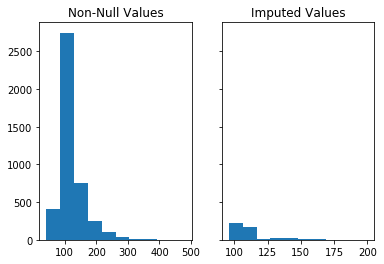

In [9]:
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

#view all imputed values next to actual distribution as a sanity check
ax1.set_title('Non-Null Values')
ax1.hist(train_demo.loc[~pd.isnull(train['Last Preoperative Glucose Value ']), 'LastPreopGlucose'])

ax2.set_title('Imputed Values')
ax2.hist(train_demo.loc[pd.isnull(train['Last Preoperative Glucose Value ']), 'LastPreopGlucose'])

plt.show()

Visualize imputed values versus real values

In [10]:
#see if any columns have nulls
print(train_demo.count())
#see if any columns have infinity
print(train_demo.max().to_frame().T)

DM__0.0             4769
DM__1.0             4769
DM__2.0             4769
HbA1C_4.0           4769
HbA1C_4.5           4769
HbA1C_5.0           4769
HbA1C_5.5           4769
HbA1C_6.0           4769
HbA1C_6.5           4769
HbA1C_7.0           4769
HbA1C_7.5           4769
HbA1C_8.0           4769
HbA1C_8.5           4769
HbA1C_9.0           4769
HbA1C_9.5           4769
HbA1C_10.0          4769
HbA1C_10.5          4769
HbA1C_11.0          4769
HbA1C_11.5          4769
HbA1C_12.0          4769
HbA1C_12.5          4769
HbA1C_13.0          4769
HbA1C_14.0          4769
HbA1C_<4.0          4769
Gender__F           4769
Gender__M           4769
Gender__U           4769
BMI                 4769
Age                 4769
LastPreopGlucose    4769
dtype: int64
   DM__0.0  DM__1.0  DM__2.0  HbA1C_4.0  HbA1C_4.5  HbA1C_5.0  HbA1C_5.5  \
0      1.0      1.0      1.0        1.0        1.0        1.0        1.0   

   HbA1C_6.0  HbA1C_6.5  HbA1C_7.0        ...         HbA1C_12.5  HbA1C_13.0  \
0   

Ensure data is clean for training.

In [11]:
#Hyperparameter sweep for K-Nearest Neighbors, Bernoulli NB, Logistic Regression, Random Forests
KNNHyper_demo = HyperParameters(KNeighborsClassifier(), {'n_neighbors': [1, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175]}, train_demo, train.HyperglycemicIncident)
BNBHyper_demo = HyperParameters(BernoulliNB(),{'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}, train_demo, train.HyperglycemicIncident)
LRHyper_demo = HyperParameters(LogisticRegression(penalty='l2'),{'C': np.arange(1,15)}, train_demo, train.HyperglycemicIncident)
RFHyper_demo = HyperParameters(RandomForestClassifier(),{'n_estimators': np.arange(1,15),'max_features': np.arange(1,15),'max_depth': np.arange(1,15)}, train_demo, train.HyperglycemicIncident)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [12]:
#show best performing parameters
print("Best KNN: ")
print(KNNHyper_demo[KNNHyper_demo.mean_validation_score == np.max(KNNHyper_demo.mean_validation_score)])

print("Best BNB: ")
print(BNBHyper_demo[BNBHyper_demo.mean_validation_score == np.max(BNBHyper_demo.mean_validation_score)])

print("Best LR: ")
print(LRHyper_demo[LRHyper_demo.mean_validation_score == np.max(LRHyper_demo.mean_validation_score)])

print("Best RF: ")
print(RFHyper_demo[RFHyper_demo.mean_validation_score == np.max(RFHyper_demo.mean_validation_score)])
list(RFHyper_demo[RFHyper_demo.mean_validation_score == np.max(RFHyper_demo.mean_validation_score)].parameters)

Best KNN: 
              parameters  mean_validation_score
11  {'n_neighbors': 175}               0.534494
Best BNB: 
       parameters  mean_validation_score
7  {'alpha': 2.0}                0.49633
Best LR: 
   parameters  mean_validation_score
4    {'C': 5}                0.54393
13  {'C': 14}                0.54393
Best RF: 
                                            parameters  mean_validation_score
777  {'max_depth': 4, 'max_features': 14, 'n_estima...               0.560495


[{'max_depth': 4, 'max_features': 14, 'n_estimators': 8}]

Parameter sweeps show the best parameterizations using cross validation within training set

In [13]:
#best models
KNN_demo = KNeighborsClassifier(n_neighbors = 175)
BNB_demo = BernoulliNB(alpha = 2)
LRHyper_demo = LogisticRegression(C = 6)
RFHyper_demo = RandomForestClassifier(max_depth=6,max_features=10,n_estimators=11)

#test data processing
#Hospital focused processing

#Used for regression imputing last preoperative glucose values, but facing some issues with those values
test_demo = pd.concat([pd.get_dummies(test['DM type'],prefix='DM_'),pd.get_dummies(test['HbA1C (Last one within 6 mo)'],prefix='HbA1C'),pd.get_dummies(test.Gender,prefix='Gender_'), test[['BMI','Age']]],axis=1)
test_demo['LastPreopGlucose'] = test['Last Preoperative Glucose Value ']

#instead using mean value imputation
test_demo = normalizeTrainTest(train_demo, test_demo)
test_demo.loc[pd.isnull(test_demo['LastPreopGlucose']), 'LastPreopGlucose'] = np.rint(ImputeRegression.predict(test_demo.loc[pd.isnull(test_demo['LastPreopGlucose']), test_demo.columns != 'LastPreopGlucose']))
#test_demo.loc[pd.isnull(test_demo['LastPreopGlucose']), 'LastPreopGlucose'] = np.median(train.loc[~pd.isnull(train['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '])

KNN_demo.fit(train_demo, train.HyperglycemicIncident)
BNB_demo.fit(train_demo, train.HyperglycemicIncident)
LRHyper_demo.fit(train_demo, train.HyperglycemicIncident)
RFHyper_demo.fit(train_demo, train.HyperglycemicIncident)

HbA1C_13.5
Gender__U


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
#accuracies of each of the optimally parameterized models
print("KNN: ", str(round(accuracy_score(test.HyperglycemicIncident, KNN_demo.predict(test_demo)),4)))
print("BNB: ", str(round(accuracy_score(test.HyperglycemicIncident, BNB_demo.predict(test_demo)),4)))
print("LR: ", str(round(accuracy_score(test.HyperglycemicIncident, LRHyper_demo.predict(test_demo)),4)))
print("RF: ", str(round(accuracy_score(test.HyperglycemicIncident, RFHyper_demo.predict(test_demo)),4)))

KNN:  0.5489
BNB:  0.4907
LR:  0.5475
RF:  0.5548


demographic accuracies are in the low 50% range. 

In [15]:
#View confusion matrix for best performing model to ensure reasonable prediction distribution
confusion_matrix(test.HyperglycemicIncident, RFHyper_demo.predict(test_demo))

array([[755,  69,  78],
       [339, 135, 127],
       [207,  90, 244]], dtype=int64)

View confusion matrix of predictions to ensure we don't have an overwhelming bias.

In [16]:
#Second category of attributes: hospital focused processing
train_Hospital = pd.concat([pd.get_dummies(train.Anesthesiologist1,prefix='Anesth_'),pd.get_dummies(train.Surgeon,prefix='Surgeon_'),pd.get_dummies(train.CRNA1,prefix='CRNA_'),pd.get_dummies(train.Resident1,prefix='Resident_')],axis=1)


Repeat above process for hospital related data.

In [17]:
KNNHyper_hosp = HyperParameters(KNeighborsClassifier(), {'n_neighbors': [1, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175]}, train_Hospital, train.HyperglycemicIncident)
BNBHyper_hosp = HyperParameters(BernoulliNB(),{'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}, train_Hospital, train.HyperglycemicIncident)
LRHyper_hosp = HyperParameters(LogisticRegression(penalty='l2'),{'C': np.arange(1,15)}, train_Hospital, train.HyperglycemicIncident)
RFHyper_hosp = HyperParameters(RandomForestClassifier(),{'n_estimators': np.arange(1,15),'max_features': np.arange(1,15),'max_depth': np.arange(1,15)}, train_Hospital, train.HyperglycemicIncident)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [18]:
print("Best KNN: ")
print(KNNHyper_hosp[KNNHyper_hosp.mean_validation_score == np.max(KNNHyper_hosp.mean_validation_score)])

print("Best BNB: ")
print(BNBHyper_hosp[BNBHyper_hosp.mean_validation_score == np.max(BNBHyper_hosp.mean_validation_score)])

print("Best LR: ")
print(LRHyper_hosp[LRHyper_hosp.mean_validation_score == np.max(LRHyper_hosp.mean_validation_score)])

print("Best RF: ")
print(RFHyper_hosp[RFHyper_hosp.mean_validation_score == np.max(RFHyper_hosp.mean_validation_score)])
list(RFHyper_hosp[RFHyper_hosp.mean_validation_score == np.max(RFHyper_hosp.mean_validation_score)].parameters)

Best KNN: 
              parameters  mean_validation_score
10  {'n_neighbors': 150}               0.505976
Best BNB: 
        parameters  mean_validation_score
8  {'alpha': 10.0}               0.499056
Best LR: 
  parameters  mean_validation_score
0   {'C': 1}               0.472636
Best RF: 
                                             parameters  mean_validation_score
2711  {'max_depth': 14, 'max_features': 12, 'n_estim...               0.490459


[{'max_depth': 14, 'max_features': 12, 'n_estimators': 10}]

In [19]:
#best models
KNN_hosp = KNeighborsClassifier(n_neighbors = 150)
BNB_hosp = BernoulliNB(alpha = 10)
LR_hosp = LogisticRegression(C = 1)
RF_hosp = RandomForestClassifier(max_depth=13,max_features=14,n_estimators=14)

#test data processing
#Hospital focused processing
test_Hospital = pd.concat([pd.get_dummies(test.Anesthesiologist1,prefix='Anesth_'),pd.get_dummies(test.Surgeon,prefix='Surgeon_'),pd.get_dummies(test.CRNA1,prefix='CRNA_'),pd.get_dummies(test.Resident1,prefix='Resident_')],axis=1)

KNN_hosp.fit(train_Hospital, train.HyperglycemicIncident)
BNB_hosp.fit(train_Hospital, train.HyperglycemicIncident)
LR_hosp.fit(train_Hospital, train.HyperglycemicIncident)
RF_hosp.fit(train_Hospital, train.HyperglycemicIncident)

test_Hospital = normalizeTrainTest(train_Hospital, test_Hospital)

Anesth__506900
Surgeon__7311.0
Surgeon__9432.0
Surgeon__352870.0
Surgeon__370330.0
Surgeon__389360.0
Surgeon__468511.0
CRNA__414260.0
CRNA__503295.0
CRNA__509157.0
Anesth__7298
Anesth__292070
Anesth__510903
Surgeon__1735.0
Surgeon__2322.0
Surgeon__5228.0
Surgeon__5621.0
Surgeon__7001.0
Surgeon__8207.0
Surgeon__8941.0
Surgeon__222540.0
Surgeon__234010.0
Surgeon__237160.0
Surgeon__253310.0
Surgeon__296150.0
Surgeon__308930.0
Surgeon__318710.0
Surgeon__332890.0
Surgeon__333210.0
Surgeon__357370.0
Surgeon__379170.0
Surgeon__395200.0
Surgeon__397910.0
Surgeon__403410.0
Surgeon__408730.0
Surgeon__460205.0
Surgeon__468184.0
Surgeon__501091.0
Surgeon__502676.0
Surgeon__505882.0
Surgeon__506078.0
Surgeon__507845.0
Surgeon__510010.0
Surgeon__510350.0
CRNA__509158.0
Resident__501068.0
Resident__502213.0
Resident__509530.0
Resident__511854.0
Resident__512425.0


In [20]:
#accuracies of each of the optimally parameterized models
print("KNN: ", str(round(accuracy_score(test.HyperglycemicIncident, KNN_hosp.predict(test_Hospital)),4)))
print("BNB: ", str(round(accuracy_score(test.HyperglycemicIncident, BNB_hosp.predict(test_Hospital)),4)))
print("LR: ", str(round(accuracy_score(test.HyperglycemicIncident, LR_hosp.predict(test_Hospital)),4)))
print("RF: ", str(round(accuracy_score(test.HyperglycemicIncident, RF_hosp.predict(test_Hospital)),4)))

KNN:  0.4995
BNB:  0.5024
LR:  0.4809
RF:  0.4819


In [21]:
#confusion matrix of best performing model
confusion_matrix(test.HyperglycemicIncident, BNB_hosp.predict(test_Hospital))

array([[842,   6,  54],
       [485,  11, 105],
       [360,   7, 174]], dtype=int64)

We observe worse results for hospital data than patient demographics.

In [22]:
#Operations focused processing

#ngram_range to explore bigram & trigram possibilities?
#CV_preop = CountVectorizer(stop_words='english')
#train_CV_preop = CV_preop.fit_transform(train.PreOperativeProblemList)

#found TFIDF to vectorizer more effectively
tfidf_preop = TfidfVectorizer()
train_tfidfV_preop = tfidf_preop.fit_transform(train.PreOperativeProblemList)

#CV_proc = CountVectorizer(stop_words='english')
#train_CV_proc = CV_proc.fit_transform(train.ProcedureDescription)
tfidf_proc = TfidfVectorizer()
train_tfidf_proc = tfidf_proc.fit_transform(train.ProcedureDescription)

train_tfidf_op = sp.sparse.hstack([train_tfidf_proc, train_tfidfV_preop])
#train_cv_op = sp.sparse.hstack([train_CV_proc, train_CV_preop])

In [23]:
print('Term count:')
print(train_tfidf_op.shape[1])

print('total elements, non null elements:')
print(str(train_tfidf_op.shape[0]*train_tfidf_op.shape[1]) + ', ' + str(train_tfidf_op.nnz))

Term count:
6194
total elements, non null elements:
29539186, 93789


Using TF-IDF to transform preop and procedure notes, we have 6081 terms and a matrix density of about .0031. Very sparse.

In [24]:
KNNHyper_op = HyperParameters(KNeighborsClassifier(), {'n_neighbors': [1, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175]}, train_tfidf_op, train.HyperglycemicIncident)
BNBHyper_op = HyperParameters(BernoulliNB(),{'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}, train_tfidf_op, train.HyperglycemicIncident)
LRHyper_op = HyperParameters(LogisticRegression(penalty='l2'),{'C': np.arange(1,15)}, train_tfidf_op, train.HyperglycemicIncident)
RFHyper_op = HyperParameters(RandomForestClassifier(),{'n_estimators': np.arange(1,20),'max_features': np.arange(1,15),'max_depth': np.arange(1,20)}, train_tfidf_op, train.HyperglycemicIncident)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [25]:
print("Best KNN: ")
print(KNNHyper_op[KNNHyper_op.mean_validation_score == np.max(KNNHyper_op.mean_validation_score)])

print("Best BNB: ")
print(BNBHyper_op[BNBHyper_op.mean_validation_score == np.max(BNBHyper_op.mean_validation_score)])

print("Best LR: ")
print(LRHyper_op[LRHyper_op.mean_validation_score == np.max(LRHyper_op.mean_validation_score)])

print("Best RF: ")
print(RFHyper_op[RFHyper_op.mean_validation_score == np.max(RFHyper_op.mean_validation_score)])

list(RFHyper_op[RFHyper_op.mean_validation_score == np.max(RFHyper_op.mean_validation_score)].parameters)

Best KNN: 
            parameters  mean_validation_score
5  {'n_neighbors': 40}               0.498218
Best BNB: 
       parameters  mean_validation_score
6  {'alpha': 1.0}               0.505137
Best LR: 
  parameters  mean_validation_score
0   {'C': 1}               0.527574
Best RF: 
                                             parameters  mean_validation_score
4966  {'max_depth': 19, 'max_features': 10, 'n_estim...               0.473684


[{'max_depth': 19, 'max_features': 10, 'n_estimators': 8}]

In [26]:
#best models
KNN_op = KNeighborsClassifier(n_neighbors = 75)
BNB_op = BernoulliNB(alpha = 1.0)
LR_op = LogisticRegression(C = 1)
RF_op = RandomForestClassifier(max_depth=18,max_features=13,n_estimators=11)

#test data processing
test_op = sp.sparse.hstack([tfidf_preop.transform(test.PreOperativeProblemList),tfidf_proc.transform(test.ProcedureDescription)])

KNN_op.fit(train_tfidf_op, train.HyperglycemicIncident)
BNB_op.fit(train_tfidf_op, train.HyperglycemicIncident)
LR_op.fit(train_tfidf_op, train.HyperglycemicIncident)
RF_op.fit(train_tfidf_op, train.HyperglycemicIncident)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features=13, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [27]:
#accuracies of each of the optimally parameterized models
print("KNN: ", str(round(accuracy_score(test.HyperglycemicIncident, KNN_op.predict(test_op)),4)))
print("BNB: ", str(round(accuracy_score(test.HyperglycemicIncident, BNB_op.predict(test_op)),4)))
print("LR: ", str(round(accuracy_score(test.HyperglycemicIncident, LR_op.predict(test_op)),4)))
print("RF: ", str(round(accuracy_score(test.HyperglycemicIncident, RF_op.predict(test_op)),4)))

KNN:  0.3469
BNB:  0.3009
LR:  0.4359
RF:  0.4418


In [28]:
#we observe that using tfidf results in essentially all 0 predictions - not enough information is conveyed via text
confusion_matrix(test.HyperglycemicIncident, RF_op.predict(test_op))

array([[902,   0,   0],
       [599,   1,   1],
       [541,   0,   0]], dtype=int64)

This model doesn't have enough information - TFIDF clearly isn't doing enough to featurize the text.

## Topic Modelling for Text Data (reduce dimensionality + highlight key attributes)

Topic modelling will allow us to reduce the data dimensionality by creating topics within the data. Each text will be represented by it's similarity to each of the given topics.

In [10]:
#it's possible that the high dimensionality of the text data is reducing effectiveness of classification
#thus, we use Topic Modelling to reduce dimensionality
#identify 25 "topics" in the text
#represent each piece of freeform text as similarity to each of the 25 topics
#classify on these similarities

#credit goes to AnalyticsVidhya: https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

#import nltk
#nltk.download() # - download stopwords

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

#prepare text and create tfidf vectorizer
CleanedText = pd.concat([train.PreOperativeProblemList.apply(clean),train.ProcedureDescription.apply(clean)])
CleanedText = CleanedText.str.split()
#UnifiedTfIDF = TfidfVectorizer()
#$All_TFIDF_fit = UnifiedTfIDF.fit(CleanedText)

In [15]:
np.__version__

'1.16.1'

In [11]:
import gensim
from gensim import corpora

dictionary = corpora.Dictionary(CleanedText)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in CleanedText]

In [16]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=45, id2word = dictionary, passes=100)

In [32]:
Scores_preop = []
Scores_proc = []
    
for i in range(0,len(train)):

    toTransform_preop = dictionary.doc2bow(clean(train.PreOperativeProblemList.iloc[i]).split())
    toTransform_proc = dictionary.doc2bow(clean(train.ProcedureDescription.iloc[i]).split())
    
    transformation_preop = ldamodel.get_document_topics(toTransform_preop,minimum_probability=0)
    Scores_preop.append(np.array(transformation_preop)[:,1])
    
    transformation_proc = ldamodel.get_document_topics(toTransform_proc,minimum_probability=0)
    Scores_proc.append(np.array(transformation_proc)[:,1])


LDA_DF_preop_train = pd.DataFrame(Scores_preop, columns = ['LDA_preop_' + str(s) for s in np.arange(0,45)])
LDA_DF_proc_train = pd.DataFrame(Scores_proc, columns = ['LDA_proc_' + str(s) for s in np.arange(0,45)])

Scores_preop = []
Scores_proc = []
    
for i in range(0,len(test)):

    toTransform_preop = dictionary.doc2bow(clean(test.PreOperativeProblemList.iloc[i]).split())
    toTransform_proc = dictionary.doc2bow(clean(test.ProcedureDescription.iloc[i]).split())
    
    transformation_preop = ldamodel.get_document_topics(toTransform_preop,minimum_probability=0)
    Scores_preop.append(np.array(transformation_preop)[:,1])
    
    transformation_proc = ldamodel.get_document_topics(toTransform_proc,minimum_probability=0)
    Scores_proc.append(np.array(transformation_proc)[:,1])


LDA_DF_preop_test = pd.DataFrame(Scores_preop, columns = ['LDA_preop_' + str(s) for s in np.arange(0,45)])
LDA_DF_proc_test = pd.DataFrame(Scores_proc, columns = ['LDA_proc_' + str(s) for s in np.arange(0,45)])

In [33]:
LDA_train = pd.concat([LDA_DF_preop_train,LDA_DF_proc_train],axis=1)
LDA_test = pd.concat([LDA_DF_preop_test,LDA_DF_proc_test],axis=1)

Repeat sweep and evaluation steps on the transformed text.

In [34]:
#using a gradient boosted classifier instead of RF in these iterations
KNNHyper_lda = HyperParameters(KNeighborsClassifier(), {'n_neighbors': [1, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175]}, LDA_train, train.HyperglycemicIncident)
BNBHyper_lda = HyperParameters(BernoulliNB(),{'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}, LDA_train, train.HyperglycemicIncident)
LRHyper_lda = HyperParameters(LogisticRegression(penalty='l2'),{'C': np.arange(1,15)}, LDA_train, train.HyperglycemicIncident)
XGBtreeHyper_lda = HyperParameters(GradientBoostingClassifier(),{'n_estimators': np.arange(80,110),'max_depth': np.arange(1,6),'min_samples_leaf': np.arange(1,5)}, LDA_train, train.HyperglycemicIncident)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [35]:
print("Best KNN: ")
print(KNNHyper_lda[KNNHyper_lda.mean_validation_score == np.max(KNNHyper_lda.mean_validation_score)])

print("Best BNB: ")
print(BNBHyper_lda[BNBHyper_lda.mean_validation_score == np.max(BNBHyper_lda.mean_validation_score)])

print("Best LR: ")
print(LRHyper_lda[LRHyper_lda.mean_validation_score == np.max(LRHyper_lda.mean_validation_score)])

print("Best XGB: ")
print(XGBtreeHyper_lda[XGBtreeHyper_lda.mean_validation_score == np.max(XGBtreeHyper_lda.mean_validation_score)])
list(XGBtreeHyper_lda[XGBtreeHyper_lda.mean_validation_score == np.max(XGBtreeHyper_lda.mean_validation_score)].parameters)

Best KNN: 
            parameters  mean_validation_score
7  {'n_neighbors': 75}               0.507654
Best BNB: 
          parameters  mean_validation_score
0     {'alpha': 0.0}               0.444328
1  {'alpha': 0.0001}               0.444328
2   {'alpha': 0.001}               0.444328
3    {'alpha': 0.01}               0.444328
4     {'alpha': 0.1}               0.444328
5     {'alpha': 0.5}               0.444328
6     {'alpha': 1.0}               0.444328
7     {'alpha': 2.0}               0.444328
8    {'alpha': 10.0}               0.444328
Best LR: 
  parameters  mean_validation_score
0   {'C': 1}               0.502831
1   {'C': 2}               0.502831
Best XGB: 
                                            parameters  mean_validation_score
313  {'max_depth': 3, 'min_samples_leaf': 3, 'n_est...               0.505976


[{'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 93}]

In [36]:
#best models
KNN_LDA = KNeighborsClassifier(n_neighbors = 75)
BNB_LDA = BernoulliNB(alpha = 1.0)
LRHyper_LDA = LogisticRegression(C = 1)
XGB_LDA = GradientBoostingClassifier(max_depth=2,min_samples_leaf=4,n_estimators=83)

KNN_LDA.fit(LDA_train, train.HyperglycemicIncident)
BNB_LDA.fit(LDA_train, train.HyperglycemicIncident)
LRHyper_LDA.fit(LDA_train, train.HyperglycemicIncident)
XGB_LDA.fit(LDA_train, train.HyperglycemicIncident)

#accuracies of each of the optimally parameterized models
print("KNN: ", str(round(accuracy_score(test.HyperglycemicIncident, KNN_LDA.predict(LDA_test)),4)))
print("BNB: ", str(round(accuracy_score(test.HyperglycemicIncident, BNB_LDA.predict(LDA_test)),4)))
print("LR: ", str(round(accuracy_score(test.HyperglycemicIncident, LRHyper_LDA.predict(LDA_test)),4)))
print("XGB tree: ", str(round(accuracy_score(test.HyperglycemicIncident, XGB_LDA.predict(LDA_test)),4)))

KNN:  0.4912
BNB:  0.4413
LR:  0.4941
XGB tree:  0.4971


In [37]:
#better performance with LDA transformed text using gradient boosted decision tree, but not as high as logistic regression over LDA topics
confusion_matrix(test.HyperglycemicIncident, LRHyper_LDA.predict(LDA_test))

array([[777,  42,  83],
       [452,  54,  95],
       [314,  48, 179]], dtype=int64)

Better performance, still not great.

# Combined Classifier

In [38]:
LDA_train.index = train_demo.index
LDA_test.index = test_demo.index

In [39]:
#simple combination of all attributes
# also adding attributes that didn't seem to fit any of the above categories: appointment type and patient class
all_train = pd.concat([pd.get_dummies(train.PatientClass, prefix='class_'),pd.get_dummies(train.AppointmentTypeText, prefix='Appointment_'),LDA_train,train_demo,train_Hospital],axis=1)
all_test = pd.concat([pd.get_dummies(test.PatientClass, prefix='class_'),pd.get_dummies(test.AppointmentTypeText, prefix='Appointment_'),LDA_test,test_demo,test_Hospital],axis=1)
all_test = normalizeTrainTest(all_train,all_test)

class__D


At this point, the data was bolstered and we received "AppointmentTypeText" and "PatientClass" - two very simple and powerfully predictive variables. Added these in with the overall classifier.

In [40]:
LR_LDA_all = LogisticRegression(C=2)
LR_LDA_all.fit(all_train, train.HyperglycemicIncident)

XGB_LDA_all = GradientBoostingClassifier(max_depth=3,min_samples_leaf=4,n_estimators=102)
XGB_LDA_all.fit(all_train, train.HyperglycemicIncident)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=102,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [41]:
print("XGB tree: ", str(round(accuracy_score(test.HyperglycemicIncident, XGB_LDA_all.predict(all_test)),4)))
print("LR: ", str(round(accuracy_score(test.HyperglycemicIncident, LR_LDA_all.predict(all_test)),4)))

print("XGB confusion matrix: ")
print(confusion_matrix(test.HyperglycemicIncident, XGB_LDA_all.predict(all_test)))
print("LR confusion matrix: ")
print(confusion_matrix(test.HyperglycemicIncident, LR_LDA_all.predict(all_test)))

XGB tree:  0.6199
LR:  0.5846
XGB confusion matrix: 
[[758 109  35]
 [288 204 109]
 [113 123 305]]
LR confusion matrix: 
[[713 129  60]
 [288 156 157]
 [122  93 326]]


In [42]:
#testing results of a one vs all classifier instead of a 3-class classifier - results are similar
from sklearn.multiclass import OneVsRestClassifier
XGB_OneVAll = OneVsRestClassifier(GradientBoostingClassifier(max_depth=3,min_samples_leaf=4,n_estimators=102))
LR_OneVAll = OneVsRestClassifier(LogisticRegression(C=2))

XGB_OneVAll.fit(all_train, train.HyperglycemicIncident)
LR_OneVAll.fit(all_train, train.HyperglycemicIncident)

print("XGB tree: ", str(round(accuracy_score(test.HyperglycemicIncident, XGB_OneVAll.predict(all_test)),4)))
print("LR: ", str(round(accuracy_score(test.HyperglycemicIncident, LR_OneVAll.predict(all_test)),4)))

print("XGB confusion matrix: ")
print(confusion_matrix(test.HyperglycemicIncident, XGB_OneVAll.predict(all_test)))
print("LR confusion matrix: ")
print(confusion_matrix(test.HyperglycemicIncident, LR_OneVAll.predict(all_test)))

XGB tree:  0.6179
LR:  0.5851
XGB confusion matrix: 
[[766  97  39]
 [294 185 122]
 [122 107 312]]
LR confusion matrix: 
[[714 128  60]
 [288 157 156]
 [122  94 325]]


We can see that the XGB tree outperforms logistic regression in both the one versus all and multiclass classification settings.

In [43]:
#Show XGB feature importance
pd.Series(XGB_LDA_all.feature_importances_,index=all_test.columns).sort_values(ascending=False)

LastPreopGlucose               0.122570
Age                            0.033198
Appointment__CARDIO SURGERY    0.031357
BMI                            0.028831
LDA_proc_7                     0.022092
LDA_preop_3                    0.020845
LDA_proc_1                     0.019935
LDA_proc_39                    0.018941
LDA_preop_44                   0.016132
LDA_proc_8                     0.015513
LDA_proc_12                    0.015438
LDA_proc_19                    0.015235
LDA_proc_26                    0.013706
LDA_proc_16                    0.013555
LDA_preop_20                   0.013489
LDA_proc_11                    0.013009
LDA_preop_27                   0.012429
LDA_proc_25                    0.011538
LDA_preop_8                    0.011346
LDA_preop_42                   0.011315
LDA_proc_40                    0.011189
LDA_proc_36                    0.010711
DM__0.0                        0.010684
class__I                       0.010480
LDA_proc_37                    0.010315


As expected, the last preoperative glucose is the most important variable while surgeon (a hospital variable) provided little use.

# Classification using Neural Network (Keras)

In [44]:
import tensorflow as tf
from tensorflow import keras

In [45]:
all_train.shape
#all_test

(4769, 555)

In [46]:
#Deep model - start with 555 features, dropout rate of .05 at each layer
#2 hidden layers, one cuts nodes by 1/5, next down to 10
model = keras.Sequential([
    keras.layers.Dense(555, activation=tf.nn.relu),
    keras.layers.Dropout(.05, noise_shape=None, seed=None),
    keras.layers.Dense(111, activation=tf.nn.relu),
    keras.layers.Dropout(.05, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dropout(.05, noise_shape=None, seed=None),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [47]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.fit(np.asarray(all_train), np.asarray(train.HyperglycemicIncident), epochs=50)

Epoch 1/50
4769/4769 [==============================] - 1s 155us/step - loss: 1.0947 - acc: 0.4418
Epoch 2/50
4769/4769 [==============================] - 0s 98us/step - loss: 1.0225 - acc: 0.4710
Epoch 3/50
4769/4769 [==============================] - 0s 99us/step - loss: 1.0647 - acc: 0.5041
Epoch 4/50
4769/4769 [==============================] - 0s 103us/step - loss: 1.0098 - acc: 0.5408
Epoch 5/50
4769/4769 [==============================] - 1s 105us/step - loss: 1.0117 - acc: 0.5183
Epoch 6/50
4769/4769 [==============================] - 0s 99us/step - loss: 0.9630 - acc: 0.5641
Epoch 7/50
4769/4769 [==============================] - 0s 97us/step - loss: 0.9439 - acc: 0.5708
Epoch 8/50
4769/4769 [==============================] - 0s 101us/step - loss: 0.9311 - acc: 0.5785
Epoch 9/50
4769/4769 [==============================] - 0s 99us/step - loss: 0.9185 - acc: 0.5840
Epoch 10/50
4769/4769 [==============================] - 0s 97us/step - loss: 0.9102 - acc: 0.5852
Epoch 11/50
476

In [49]:
test_loss, test_acc = model.evaluate(np.array(all_test), np.array(test.HyperglycemicIncident))

print('Test accuracy:', test_acc)

2044/2044 [==============================] - 0s 50us/step
Test accuracy: 0.575831702894


In [51]:
confusion_matrix(np.apply_along_axis(np.argmax,1,model.predict(np.array(all_test))),test.HyperglycemicIncident)

array([[688, 301, 116],
       [165, 175, 111],
       [ 49, 125, 314]], dtype=int64)

We observe that performance is nearly as good as the gradient boosted decision tree that was previously the accuracy king. We note that the distribution of predictions is roughly the same.

Normalized confusion matrix
[[ 0.62  0.27  0.1 ]
 [ 0.37  0.39  0.25]
 [ 0.1   0.26  0.64]]
Normalized confusion matrix
[[ 0.84  0.12  0.04]
 [ 0.48  0.34  0.18]
 [ 0.21  0.23  0.56]]


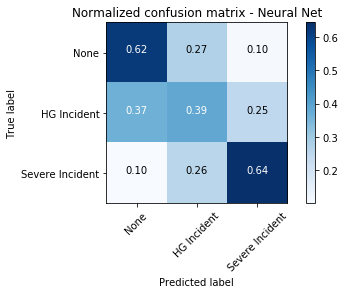

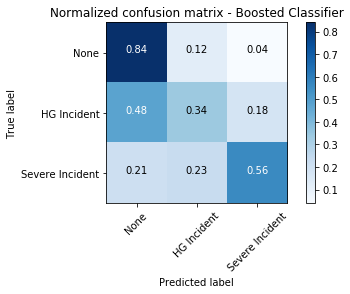

In [53]:
# Compute confusion matrix for NN
cnf_matrix = confusion_matrix(np.apply_along_axis(np.argmax,1,model.predict(np.array(all_test))),test.HyperglycemicIncident)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['None','HG Incident','Severe Incident'], normalize=True,
                      title='Normalized confusion matrix - Neural Net')

# Compute confusion matrix for XGB tree
cnf_matrix = confusion_matrix(test.HyperglycemicIncident, XGB_LDA_all.predict(all_test))
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['None','HG Incident','Severe Incident'], normalize=True,
                      title='Normalized confusion matrix - Boosted Classifier')

plt.show()

Finalizing these classification results and making a prettier confusion matrix.

# Continuous prediction later binned into discrete buckets

One thought was to predict peak glucose level as a continuous variable and then bin that prediction into the associated class.

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [55]:
#added additional data: patient class and appointment type
#attempted with broad specification and narrow, find better performance with narrow
#ideally would perform stepwise model search, unsure how to do this in python
#train_dummies = pd.concat([pd.get_dummies(train.PatientClass),pd.get_dummies(train.AppointmentTypeText),pd.get_dummies(train.Gender),pd.get_dummies(train['HbA1C (Last one within 6 mo)']), train.BMI, train['Last Preoperative Glucose Value '], LDA_train, train_Hospital],axis=1)
train_dummies = pd.concat([pd.get_dummies(train.PatientClass),pd.get_dummies(train.AppointmentTypeText),pd.get_dummies(train.Gender),pd.get_dummies(train['HbA1C (Last one within 6 mo)']), train.BMI, train['Last Preoperative Glucose Value ']],axis=1)
#test_dummies = pd.concat([pd.get_dummies(test.PatientClass),pd.get_dummies(test.AppointmentTypeText),pd.get_dummies(test.Gender),pd.get_dummies(test['HbA1C (Last one within 6 mo)']), test.BMI, test['Last Preoperative Glucose Value '], LDA_test, test_Hospital],axis=1)
test_dummies = pd.concat([pd.get_dummies(test.PatientClass),pd.get_dummies(test.AppointmentTypeText),pd.get_dummies(test.Gender),pd.get_dummies(test['HbA1C (Last one within 6 mo)']), test.BMI, test['Last Preoperative Glucose Value ']],axis=1)

Used both regression and SVR models. Removed outliers from the training data since outliers can be high leverage in a regression setting.

In [56]:
#Narrowing training set to exclude outliers, which can have a larger impact on regression models
train_dummies = train_dummies[(train.Weight < 500) & (train.Weight != 0)]
train_dummies = train_dummies[(train['Last Preoperative Glucose Value '] < 500)]
train_dummies = train_dummies[(train['Peak glucose value'] < 500)]

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [57]:
train_dummies.loc[pd.isnull(train_dummies['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '] = np.median(train.loc[~pd.isnull(train['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '])
test_dummies.loc[pd.isnull(test_dummies['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '] = np.median(train.loc[~pd.isnull(train['Last Preoperative Glucose Value ']), 'Last Preoperative Glucose Value '])
test_dummies = normalizeTrainTest(train_dummies,test_dummies)

13.5
D
U


In [58]:
ContLR = LinearRegression()
ContSVR = SVR(C=20)

truncLabels = train.loc[(train.Weight < 500) & (train.Weight != 0) & (train['Last Preoperative Glucose Value '] < 500) & (train['Peak glucose value'] < 500), 'Peak glucose value']

ContLR.fit(train_dummies,truncLabels)
ContSVR.fit(train_dummies,truncLabels)

SVR(C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [59]:
test['LR_pred'] = ContLR.predict(test_dummies)
test['SVR_pred'] = ContSVR.predict(test_dummies)

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
test['LR_pred_cat'] = 1
test['SVR_pred_cat'] = 1

test.loc[test.LR_pred < 140, 'LR_pred_cat'] = 0
test.loc[test.SVR_pred < 140, 'SVR_pred_cat'] = 0

test.loc[test.LR_pred > 180, 'LR_pred_cat'] = 2
test.loc[test.SVR_pred > 180, 'SVR_pred_cat'] = 2

C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\nivelaga\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [61]:
print('LR accuracy: ' + str(accuracy_score(test.HyperglycemicIncident, test.LR_pred_cat)))
print(confusion_matrix(test.HyperglycemicIncident, test.LR_pred_cat))
print('SVR accuracy: ' + str(accuracy_score(test.HyperglycemicIncident, test.SVR_pred_cat)))
print(confusion_matrix(test.HyperglycemicIncident, test.SVR_pred_cat))

LR accuracy: 0.548923679061
[[486 394  22]
 [133 380  88]
 [ 51 234 256]]
SVR accuracy: 0.518590998043
[[536 360   6]
 [175 378  48]
 [ 72 323 146]]


Linear regression outperforms SVRs.

Normalized confusion matrix
[[ 0.54  0.44  0.02]
 [ 0.22  0.63  0.15]
 [ 0.09  0.43  0.47]]


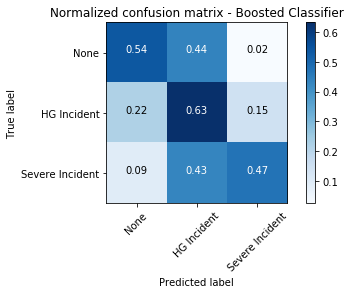

In [62]:
# Compute confusion matrix for XGB tree
cnf_matrix = confusion_matrix(test.HyperglycemicIncident, test.LR_pred_cat)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['None','HG Incident','Severe Incident'], normalize=True,
                      title='Normalized confusion matrix - Boosted Classifier')

plt.show()

And finally, to print the coefficients. We see that HBA1C values are heavily weighted, as are varies appointment types.

In [63]:
pd.Series(ContLR.coef_,index = train_dummies.columns).sort_values()


14.0                               -30.545820
11.0                               -15.227015
ORAL SURGERY                       -14.669616
PLASTIC                            -12.930522
ORTHOPEDICS                        -10.398967
9.0                                 -9.058594
9.5                                 -9.034522
4.5                                 -8.103559
7.5                                 -7.517167
6.5                                 -5.971133
NEUROSURGERY                        -5.672134
O                                   -5.624213
6.0                                 -5.584257
GYNECOLOGY                          -5.422222
PLASTICS                            -5.377166
UROLOGY                             -4.684687
8.5                                 -4.608813
M                                   -4.213913
5.5                                 -3.988718
GENERAL SURGERY                     -3.218700
B                                   -2.986229
VASCULAR SURGERY                  

That's all! Seems that plain classification is better accuracy than regression + binning by about 5 percentage points. Additionally, we observe that the best performance is obtained with a gradient boosted decision tree. I note that not much time was spent on optimizing network structure: it's possible that sweeping over layers/dropout structure would have further boosted the predictive power of the network.